# Assignment 3

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt


# Problem 1 (8+2 = 10 pts): Apply Variational Autoencoder on the CIFAR10 Dataset. Number of epochs should be minimum of 100.

In [3]:
# Load CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

170498071/170498071 [==============================] - 2s 0us/step


In [4]:
# Check shapes of the dataset
print("Train images shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

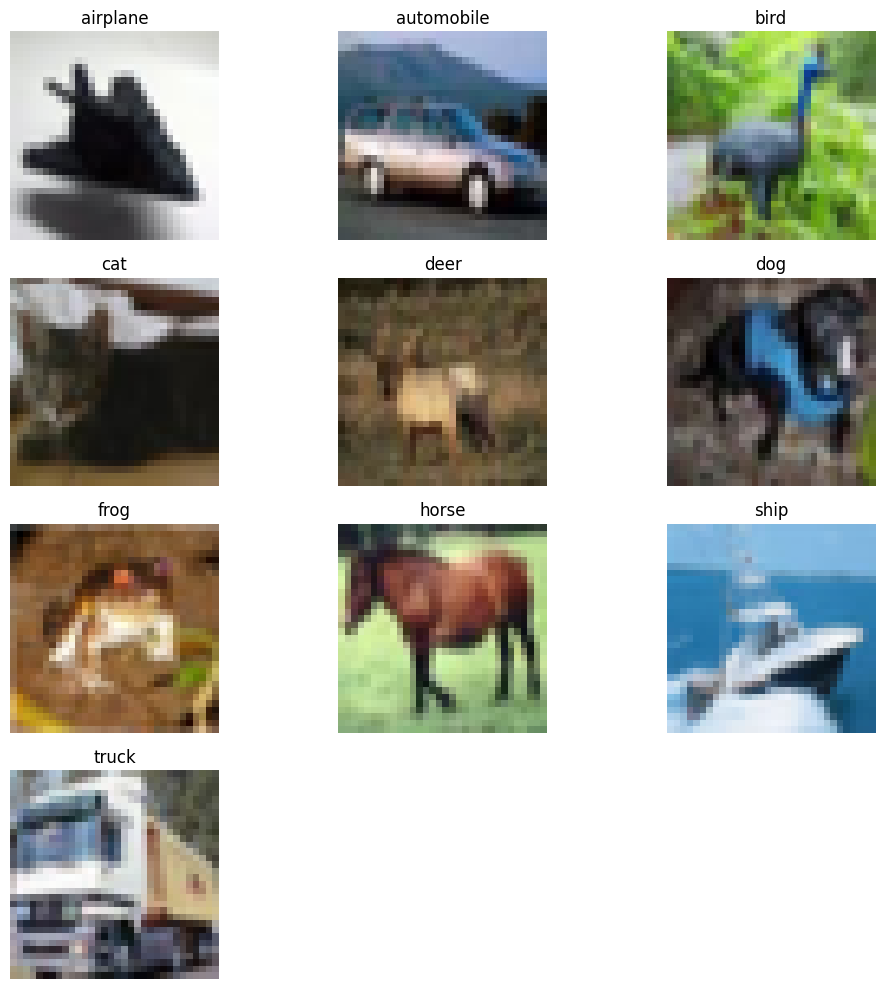

In [7]:
def display_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    class_types = len(class_names)

    labels = labels.flatten()

    indices = []
    for j in range(len(class_names)):
        for i in range(len(labels)):
            if labels[i] == j:
                indices.append(i)
                break

    for i in range(class_types):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[indices[i]])
        plt.title(class_names[labels[indices[i]]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

display_images(x_train, y_train, class_names)

# a. Use minimum of 4 convolutional layers in the encoder and 4 deconvolutional layers (Conv2DTranspose/ upscale) in the decoder.

In [ ]:
# Define the encoder
encoder_inputs = Input(shape=(32, 32, 3))
latent_size = 64

# Encoder
x = encoder_inputs

encoder_inputs = Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)

# Flatten and Dense layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

# Latent space
latent_space_mean = layers.Dense(latent_size)(x)
latent_space_log_var = layers.Dense(latent_size)(x)

# Final Encoder Model
encoder = models.Model(encoder_inputs, [latent_space_mean, latent_space_log_var], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 16, 16, 32)           896       ['input_5[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_5[0][0]']            
                                                                                            

In [ ]:
# Decoder
latent_inputs = Input(shape=(latent_size,))
x = layers.Dense(2 * 2 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((2, 2, 256))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding='same')(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', strides=2, padding='same')(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

# Final Decoder Model
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              66560     
                                                                 
 reshape_1 (Reshape)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 4, 4, 128)         295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 8, 8, 64)          73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 16, 16, 32)        1846

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
vae.fit(x_train, x_train, epochs=100, validation_data=(x_test, x_test))

Epoch 1/100
1563/1563 [==============================] - 14s 9ms/step - loss: 0.6704 - val_loss: 0.6703
Epoch 2/100
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6698 - val_loss: 0.6699
Epoch 3/100
1563/1563 [==============================] - 14s 9ms/step - loss: 0.6695 - val_loss: 0.6699
Epoch 4/100
1563/1563 [==============================] - 13s 9ms/step - loss: 0.6696 - val_loss: 0.6702
Epoch 5/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6695 - val_loss: 0.6709
Epoch 6/100
1563/1563 [==============================] - 14s 9ms/step - loss: 0.6696 - val_loss: 0.6695
Epoch 7/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6695 - val_loss: 0.6696
Epoch 8/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6692 - val_loss: 0.6701
Epoch 9/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6694 - val_loss: 0.6697
Epoch 10/100
1563/1563 [==============================] - 13s 8

# b. Display how the latent space clusters different classes of the training data.

1563/1563 [==============================] - 5s 3ms/step


<ipython-input-29-a29ef1ae7d23>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


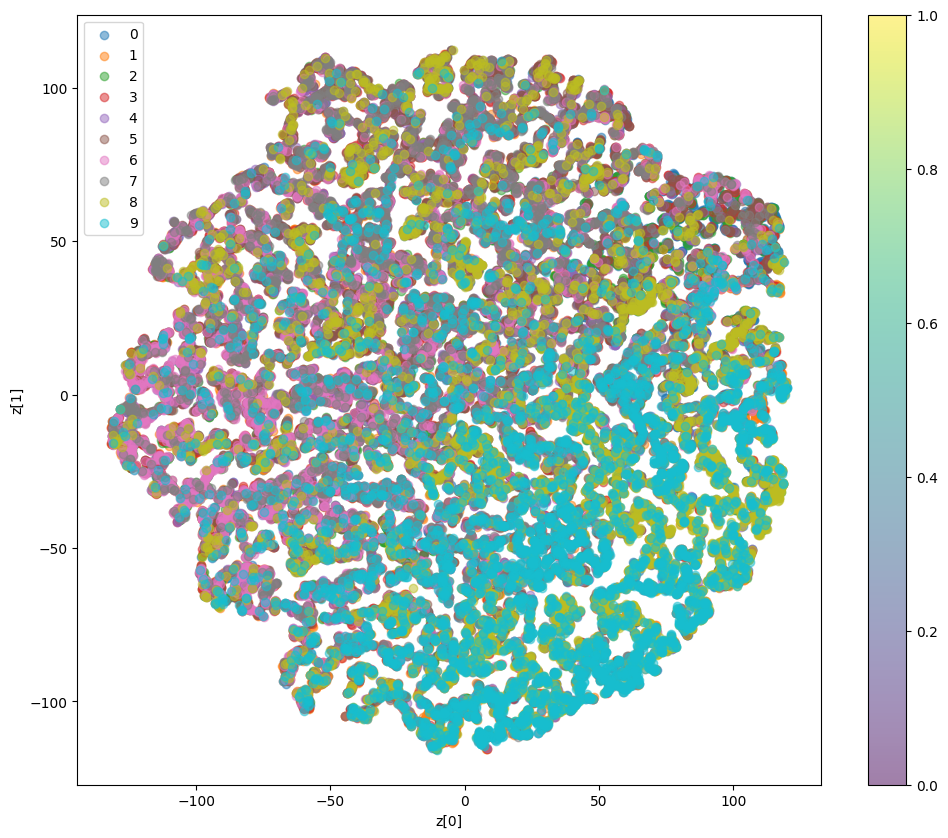

In [ ]:
# Load the CIFAR-10 data including labels
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Get the latent space representation (z_mean) of the training data
z_mean, _ = encoder.predict(x_train)
from sklearn.manifold import TSNE

# Use t-SNE to reduce dimensionality for visualization
z_mean_tsne = TSNE(n_components=2).fit_transform(z_mean)
import matplotlib.pyplot as plt

# Function to plot with labels
def plot_latent_space(z_mean, labels):
    plt.figure(figsize=(12, 10))
    cmap = plt.cm.get_cmap('tab10')
    for i in range(10):  # CIFAR-10 has 10 classes
        indices = np.where(labels == i)[0]
        plt.scatter(z_mean[indices, 0], z_mean[indices, 1], c=np.array([cmap(i)]), label=i, alpha=0.5)
    plt.colorbar()
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.legend()
    plt.show()

# Plot the result of t-SNE reduction
plot_latent_space(z_mean_tsne, y_train)

# As we can see most of the clusters are of the class 9 followed by 8, which belongs to the class truck and ship.